## Abstract
----

UMAP is a powerful tool for dimensionality reduction, but its nonlinearity makes it difficult to directly interpret clusters in terms of the input features. We show how to enable direct and exact interpretation through a locally linear (but still globally nonlinear) implementation of the UMAP embedding function with deep networks.

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on AirTable, SlackBot will message you an AI disclosure that you should place here.
:::

## Introduction

UMAP (uniform manifold approximation and projection) is a powerful tool for nonlinear dimensionality reduction, and it has been applied across a wide range of fields. Here we present an additional tool for UMAP embeddings that generates exact feature attributions for each point in the dataset.

Principal components analysis (PCA) was the original method for dimensionality reduction, but has fallen out of favor due to its weakness in forming clusters for complex datasetgs (although it still has many uses, including as a preprocessing step for these nonlinear methods). Despite its lack of power in forming separate clusters, PCA was interpretable, in that it simply projected inputs linearly along the principal component feature vectors. The principal components were the weights on input features that gave rise to the lower-dimensional embeddings.

For more complex datasets popular in the era of deep learning, the clusters produced from PCA latent embeddings were not distinct enough. For example, PCA on the classic MNIST dataset of hand-drawn digits produces some distinct clusters, but many overlapping points. UMAP emerged as a powerful nonlinear alternative that could learn distinct clusters for complex datasets in an unsupervised fashion, like PCA.

However, this shift to reliance on nonlinear methods came at the cost of interpretable embeddings. Nonlinear methods are generally thought to be black boxes, although there are a range of post-hoc feature attribution methods that provide some measure of interpretability (like differential expression applied to selected clusters). UMAP is ubiquitous because of its ability to successfully learn and cluster classes for complex datasets in an unsupervised fashion, in spite of their opacity.

UMAP generates useful clusters, but PCA provided exact feature contributions. Is there any way we could have the best of both approaches? A long-known technique for interpreting nonlinear deep networks provides the key for bringing exact feature interpretability to UMAP and tSNE.
## Learn more

Refer to [Demo](/examples/demo.html) to learn about possible syntax.

In [ ]:
%%capture
!pip install scanpy

!pip install igraph
!pip install leidenalg

In [ ]:
%%capture
!pip install pytorch_lightning

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Data loaded successfully.
⚙️  Running initial preprocessing...
✅ Initial preprocessing complete.
🔬 Running quality control...


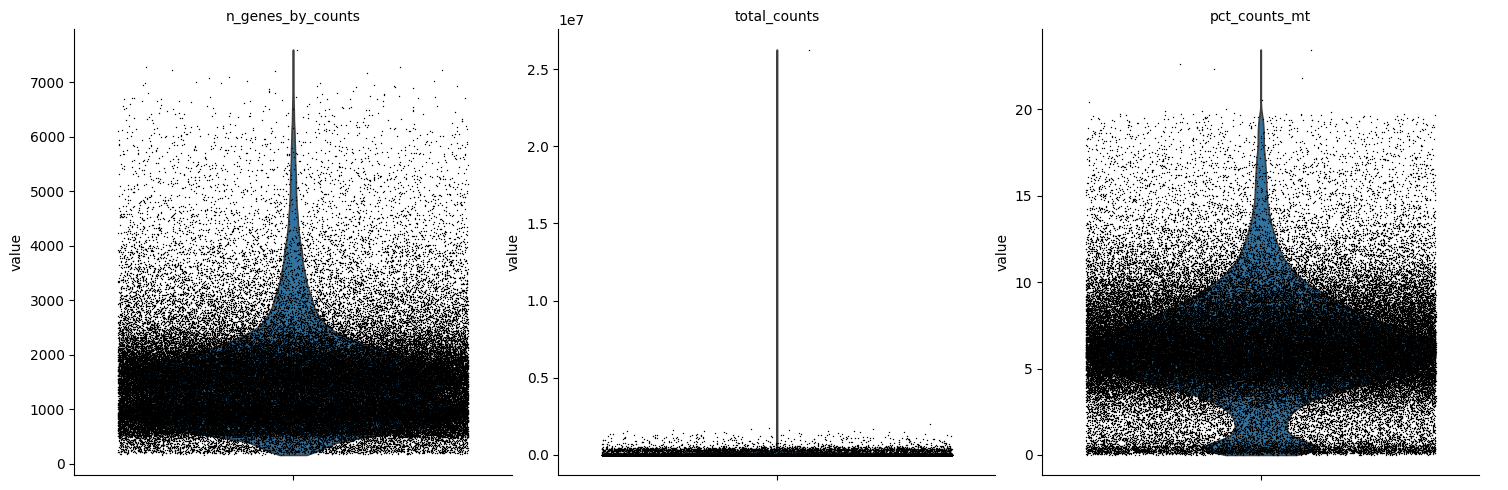

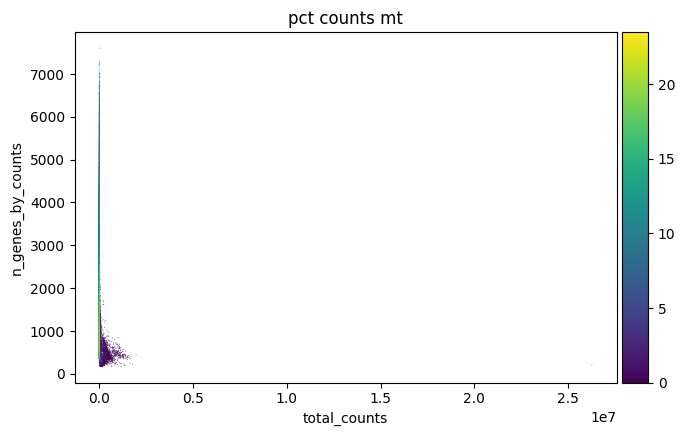

✅ Quality control complete.
🧹 Filtering data and detecting doublets...
✅ Filtering and doublet detection complete.
⚖️  Normalizing data and selecting features...


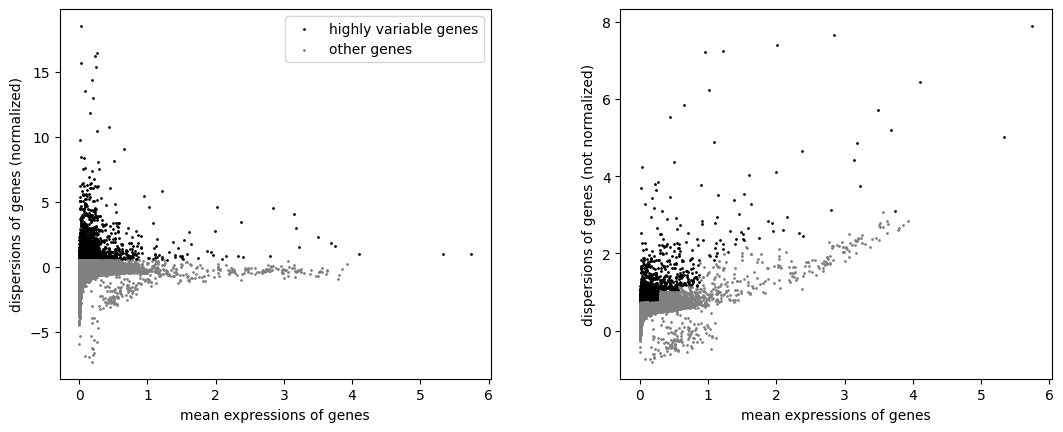

✅ Normalization and feature selection complete.
📉 Reducing dimensionality with PCA...


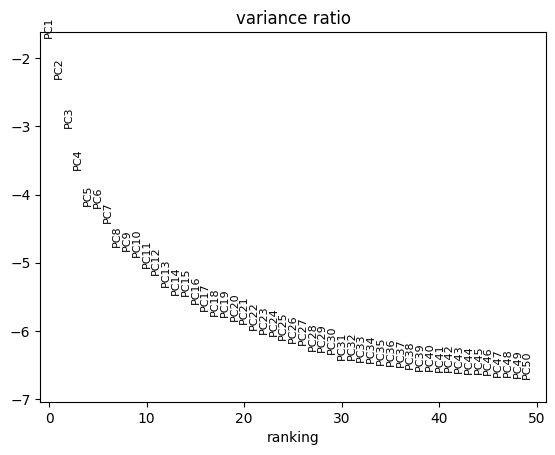

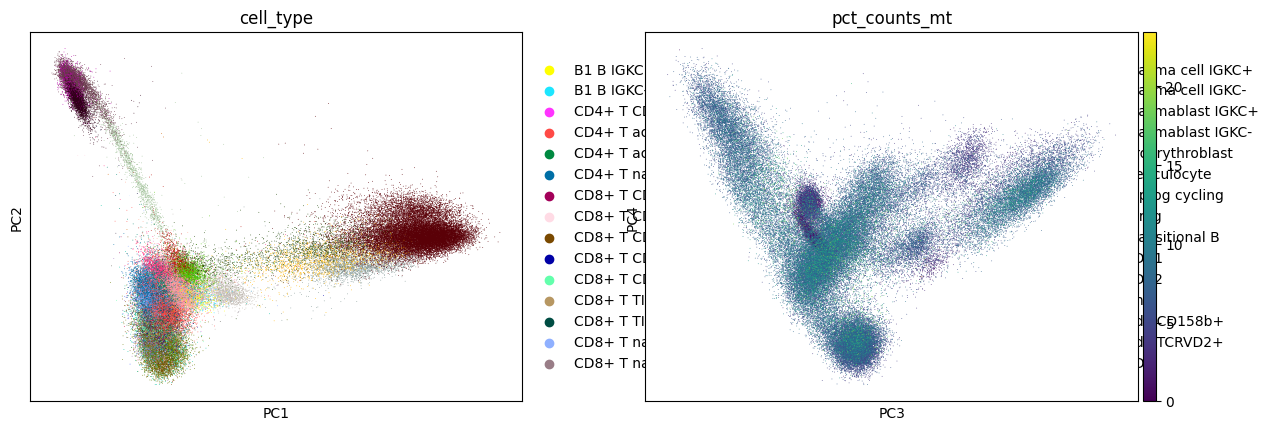

✅ PCA complete.
📊 Computing neighborhood graph, UMAP, and clusters...
✅ Embedding and clustering complete.
🎨 Generating final visualizations...


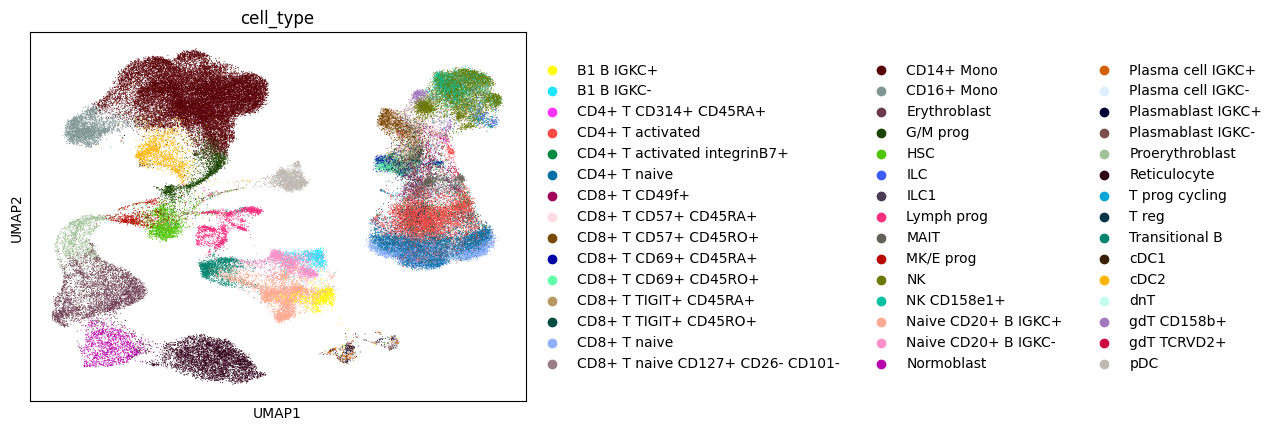

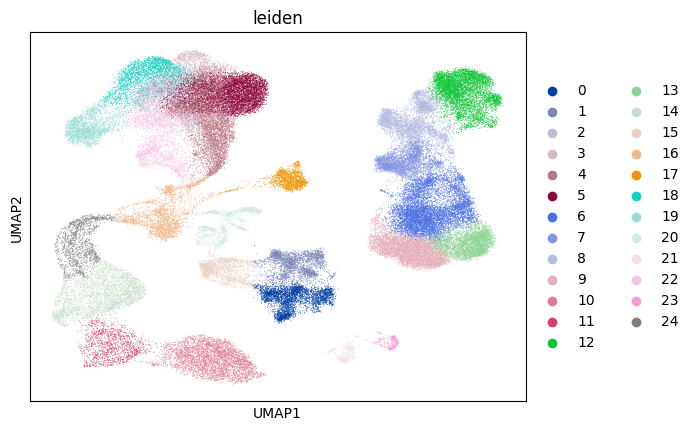

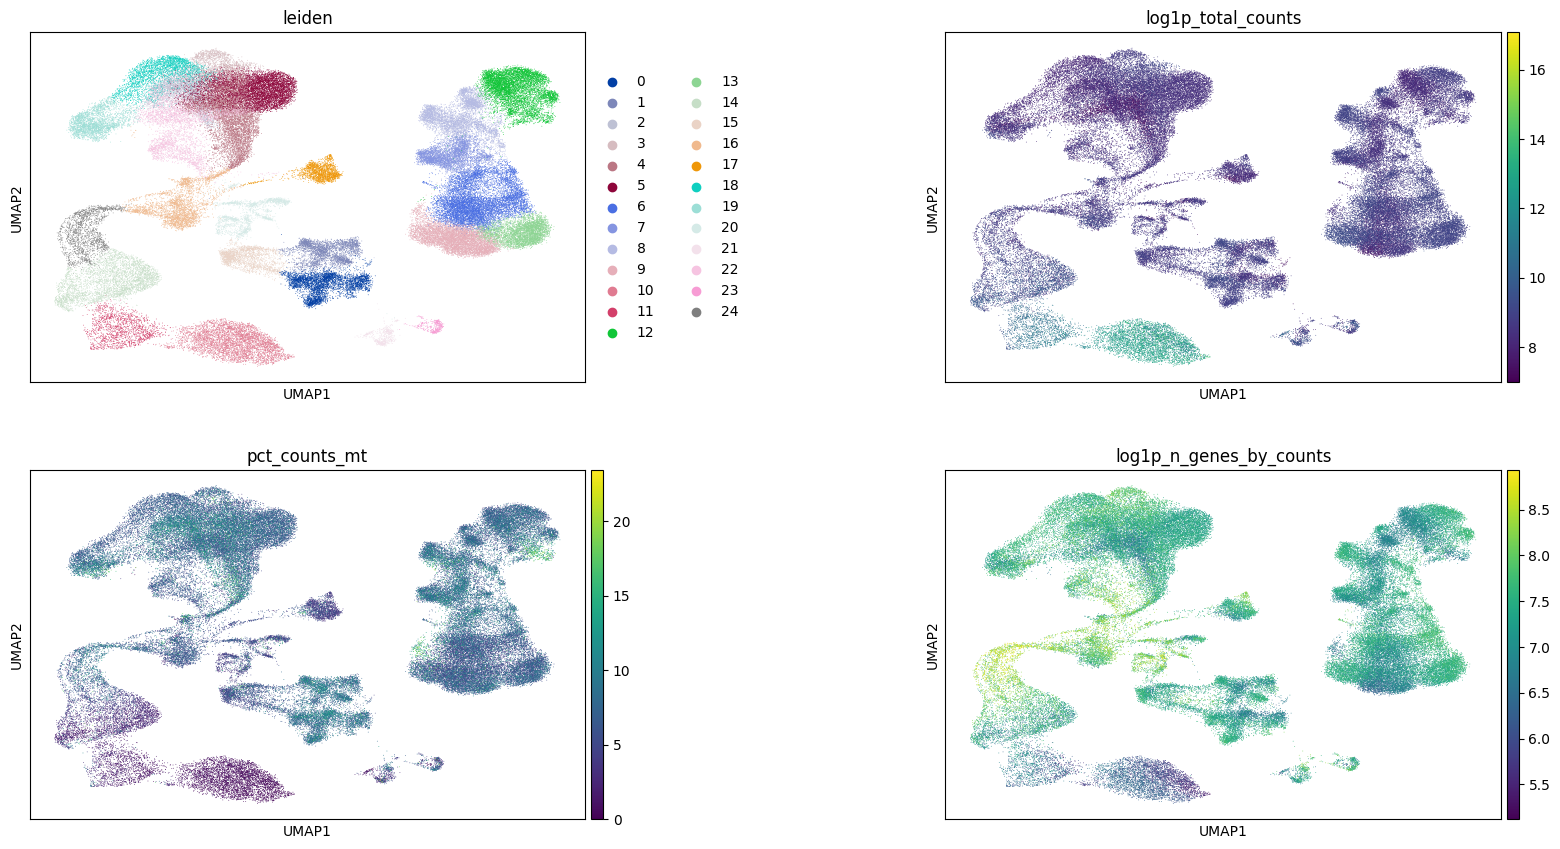

🎉 Analysis visualization complete!


In [ ]:
from src.analysis.preprocess import *

adata = preprocess_bone_marrow()

In [ ]:
non_parametric_embeddings=adata.obsm['X_umap']
non_parametric_embeddings-=non_parametric_embeddings.mean(axis=0)

In [ ]:
# --- Configuration ---
config = {
    "seed": 24,
    "pca_components": 50,
    "network_class": "deepBilinearNet", #"deepReLUNet", # "deepSiLUNet"
    "train_params": {
        "lr": 8e-4,
        "epochs": 96,
        "batch_size": 1024,
        "pumap_kwargs": {"non_parametric_embeddings": non_parametric_embeddings}
    },
    "jacobian_batch_size": 40,
    "plot_params": {
        "n_features": 16,
        "stat": "mean"
    },
    "output_filename": "bone_marrow_features.csv"
}

In [ ]:
from src.analysis.utils import PUMAP, Datamodule, Model
from src.analysis.networks import deepReLUNet, deepSiLUNet, deepBilinearNet

In [ ]:
import torch

In [ ]:
# Select cell types to analyze
config["plot_params"]["celltypes"] = adata.obs["cell_type"].value_counts().index[:5].tolist()

# Step 1: Prepare data
# from src.analysis.utils_jacobian import prepare_data
train_dataset, adata_mean_zero = prepare_data(adata, config["pca_components"])

Preparing data for training...


/tmp/ipython-input-10-4048921982.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_dataset = torch.tensor([adata.obsm["X_pca"][:, :pca_components]], dtype=torch.float32)


 Data prepared with training shape: torch.Size([1, 90261, 50])


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


 Training Parametric UMAP model...
Mon Jul 28 23:00:19 2025 Building RP forest with 20 trees
Mon Jul 28 23:00:21 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Fitting Non parametric Umap
Training NN to match embeddings


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | deepBilinearNet | 110 K  | train
----------------------------------------------------
110 K     Trainable params
0         Non-trainable params
110 K     Total params
0.442     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=96` reached.


 Model training complete.
✨ Generating and visualizing embedding...


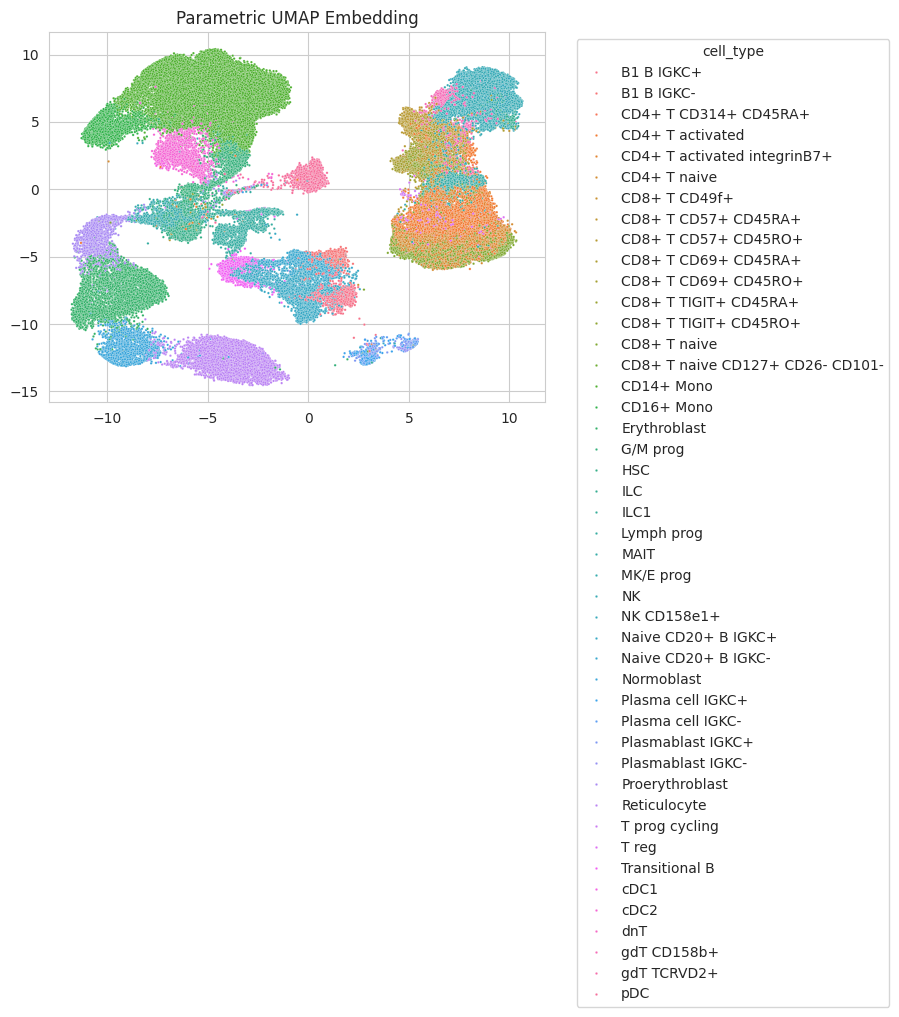

TypeError: embedding() got multiple values for argument 'basis'

In [ ]:
# Step 2: Define and train model
# Note: `network` must be an instantiated model class
from src.analysis.utils import PUMAP, Datamodule, Model
from src.analysis.networks import deepReLUNet, deepSiLUNet, deepBilinearNet

network = deepBilinearNet() # Replace with your model instantiation
encoder = train_parametric_umap(network, train_dataset, config["train_params"])

from src.analysis.utils_jacobian import generate_and_plot_embedding



In [ ]:
# Step 3: Generate and plot embedding

from src.analysis.utils_jacobian import generate_and_plot_embedding

embedding = generate_and_plot_embedding(encoder, adata, train_dataset)

In [ ]:

from src.analysis.utils_jacobian import compute_gene_space_jacobian

# Step 4: Compute Jacobian in gene space
jacobxall = compute_gene_space_jacobian(encoder.encoder, adata, train_dataset, adata_mean_zero, config["jacobian_batch_size"])


🧠 Computing Jacobian and projecting to gene space...


TypeError: unsupported operand type(s) for @: 'numpy.ndarray' and 'Tensor'

In [ ]:

# Step 5: Plot feature importances
class_genesorted = plot_feature_importance(adata, embedding, jacobxall, **config["plot_params"])

# Step 6: Export results
export_results(class_genesorted, config["output_filename"])